Charger les images: toutes les images COVID + autant d'images Pneumonie + Lung Opacity.

Visualiser un ensemble d'images aléatoire.

CNN minimal avec 1 couche de convolution et une dense.

_Résult_: le score de bonnes prédictions  et les F1-scores oscillent autour de 0.77-0.8.

V2. Improve the function 'load_images' (previous projects 2,3), add the option to choose
random seed for a RandomGenerator.
_Résult_: la sélection des images est reproductible,
la matrice de confusion varie dans les limites d'une dizaine d'unités.

CNN_28x28_1layer_3classes_v2 : images chargées en noir-et-blanc et réduites à la taille 28x28. CNN avec une couche de convolution. 3 classes. _Résultat_: Score résultant : entre 0.65 et 0.66. On remarque un grand nombre de faux négatifs (rappel = 0.54). Ce modèle a un score (taux de bonnes prédictions et F1) combarable au SVM, mais sa matrice de confision est assez différente. Ceci suggère qu'une amélioration est possible.

CNN_28x28_1layer_3classes_v3 : augmenter le nb de filtres: 8 -> 16. _Résultat_: score = 0.69 avec une matrice de confusion comparable.

CNN_64x64_1layer_3classes_v1 : augmenter la taille des images à 64x64. _Résultat:_ le score est monté à 0.73. Bémol: le modèle continue de faire beaucoup de faux négatifs (recall: 0.59). Ceci dit, l'historique montre que le modèle n'est pas allé jusqu'au bout de l'apprentissage. Mettre un CNN dans un ensemble de modèles (VotingClassifier) peut être une future option logique.


L'environnement s'appelle 'DSTest__proj_env06' sur ma machine. On trouve les versions des librairies dans la 2e cellule de code.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import cv2

# from sklearn.model_selection import train_test_split
from sklearn import metrics


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from timeit import default_timer as timer


# imports for loading and plotting data.
from load_images_limit_TOCHECK import list_img, load_data
from train_val_test_split import train_val_test_split


import time

image_path = '../data'

2024-07-15 12:07:42.853631: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 12:07:42.877544: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Added for checking versions.

import matplotlib
import sklearn
import tensorflow as tf

print(np.__version__)  # 1.26.4
print(matplotlib.__version__)  # 3.8.4
print(sklearn.__version__)  # 1.5.1
print(cv2.__version__)  # 4.9.0
print(tf.__version__)   # 2.13.1

1.26.4
3.8.4
1.5.1
4.9.0
2.13.1


Fonctions pour charger les images (adapté de: 'RF_data_augmentation.ipynb').

In [3]:
# Hyperparamètres (réduction de l'image)
# IMG_HEIGHT = 28
# IMG_WIDTH = 28


IMG_HEIGHT = 64
IMG_WIDTH = 64
# L'architecture du CNN peut aussi être déplacée ici.

In [4]:
def cond2folder(condition):
    return os.path.join(image_path, condition, "images")

Charger les images: 2500 COVID, (1250 Pneumo + 1250 Opacity), 2500 normaux choisies aléatoirement 

In [5]:
lst_conditions = ['COVID', 'Viral Pneumonia', 'Lung_Opacity', 'Normal']
lst_dirs = list(map(cond2folder, lst_conditions))
print(lst_dirs)

lst_labels = [2, 1, 1, 0]

print("labels:", lst_labels)

# determine the number of images to load
# num_COVID_img = len(list_img(lst_dirs[0]))
lst_nums_images = list(map(lambda path_dir: len(list_img(path_dir)), lst_dirs ))
print("Total number of images for each condition:", lst_nums_images)
# [3616, 6012, 1345]


['../data/COVID/images', '../data/Viral Pneumonia/images', '../data/Lung_Opacity/images', '../data/Normal/images']
labels: [2, 1, 1, 0]
Total number of images for each condition: [3616, 1345, 6012, 10192]


In [6]:
# Number of images to extract:
num_img_COV = 2500

balanced_lst_nums_images = [num_img_COV, num_img_COV//2, num_img_COV//2, num_img_COV]

print(balanced_lst_nums_images)
# [2500, 1250, 1250, 2500]



[2500, 1250, 1250, 2500]


Extract images.

In [7]:
start = time.time()
# data, labels = load_data(lst_dirs, lst_labels, balanced_lst_nums_images)
data, labels = load_data(lst_dirs,
                        lst_labels,
                        new_size=(IMG_WIDTH, IMG_HEIGHT),
                        limits=balanced_lst_nums_images,
                        random_state=42)
done = time.time()

elapsed = done - start
print(f'Loading data : {elapsed:.2f} sec \n\n')
# 7 sec

print(type(data))  # ndarray
print(data.shape)  # (7232, 28, 28, 1)

print(type(labels))  # ndarray
print(labels.shape)  # (7232,)

Loading data : 7.05 sec 


<class 'numpy.ndarray'>
(7500, 64, 64, 1)
<class 'numpy.ndarray'>
(7500,)


Show random images.

In [8]:
def subplots_random_images(tens_img: np.ndarray, labels, n_plots: int, rng):
    """
    Plot random images from the tensor 'tens_img'.

    Args:
        tens_img (3d or 4d tensor): images.
        labels (1d array-like): the labels of images.
        n_plots (int): the number of images to plot.
        rng : the random number generator

    Returns:
        fig; ax; the indices of plotted images.
    
    Possible improvement: make the 2 last parameters optional.
    """
    indices = rng.choice(tens_img.shape[0], size=n_plots, replace=False)

    fig, axes = plt.subplots(1, n_plots)
    fig.set_figheight(5)
    fig.set_figwidth(16)
    for n_plot in range(n_plots):
        axes[n_plot].imshow(tens_img.take(indices[n_plot], axis=0),
                        cmap='gray')
        axes[n_plot].set_title(labels[indices[n_plot]])
    return fig, axes, indices

(<Figure size 1600x500 with 10 Axes>,
 array([<Axes: title={'center': '2'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '0'}>, <Axes: title={'center': '2'}>,
        <Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '0'}>,
        <Axes: title={'center': '0'}>, <Axes: title={'center': '2'}>],
       dtype=object),
 array([2338, 3544, 6169,  261, 7112, 3834, 1080, 5658, 7122, 1868]))

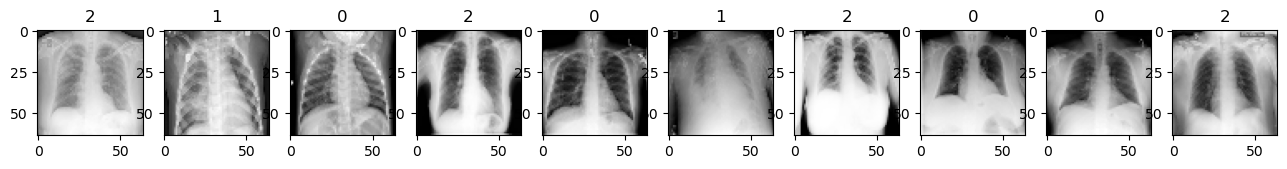

In [9]:
n_plots = 10

# Show 'n_plots' random indices.
rng = np.random.default_rng(1)

subplots_random_images(data, labels, n_plots, rng)

In [10]:
# Check the distribution of labels.
lbl_unique, lbl_counts = np.unique(labels, return_counts=True)

print(lbl_unique)  # ['0 1 2]
print('--------')
print(lbl_counts)  # [2500 2500 2500]

# As expected, the classes are balanced.


[0 1 2]
--------
[2500 2500 2500]


# train-val-test

In [11]:

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data,
                                                                labels,
                                                                random_state=42)

# (the equivalent instructions would be:)
"""
random_state=42

X_train_val, X_test, y_train_val, y_test = train_test_split(
        data,
        target,
        test_size=0.1,
        random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        test_size=0.2,
        random_state=random_state)
"""
print(X_train.shape)   # (5400, 784)
print(X_val.shape)     # (1350, 784)
print(X_test.shape)    # (750, 784)

print(y_train.shape)   # (5400,)
print(y_val.shape)     # (1350,)
print(y_test.shape)    # (750,)

(5400, 64, 64, 1)
(1350, 64, 64, 1)
(750, 64, 64, 1)
(5400,)
(1350,)
(750,)


labels -> categorical

In [12]:
# (f)
Y_train = to_categorical(y_train)
Y_val = to_categorical(y_val)

print(Y_val.shape)  # should be: (5250, 3)
print(Y_val[:3, :]) # First true values: 

(1350, 3)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


# Générateur de données
(vient du notebook 3 du module CNN)

In [13]:
train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator()


In [14]:
train_dataset = train_datagen.flow(X_train,Y_train,
                        batch_size = 128)
"""
Fails with Grayscale images!
See: https://stackoverflow.com/a/65182852

train_dataset = train_datagen.flow(X_train,Y_train,
                        batch_size = 128,
                        color_mode="grayscale")
->
TypeError: flow() got an unexpected keyword argument 'color_mode'

"""

val_dataset = test_datagen.flow(X_val, Y_val, batch_size = 128)

#  Callbacks


In [15]:
# from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

Dans le cadre de notre modèle, on utilisera deux callbacks : Un Early Stop et un Learning rate reducer.

In [16]:
early_stopping = EarlyStopping(
                                patience=5, # Attendre 5 epochs avant application
                                min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, 
    # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, #si val_loss stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.01,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 4, # On attend 4 epochs avant de réitérer 
                                    verbose=1)

time_callback = TimingCallback()

# This defined components of a CNN, but neither built a model,
# nor required resources from the machine.

# Construction d'un CNN Classique

* Couche de Convolution comportant les paramètres suivants :
    * filters = 16: La couche sera composée de 16 matrices de convolution.
    * kernel_size = (3, 3) : le noyau de convolution sera de dimension 3x3.
    * activation = 'relu'.
    * input_shape =  (100,100,3).
    * On ajoutera les paramètres padding = 'valid' et kernel_regularizer=regularizers.l2(0.00001).

* Couche de Max Pooling avec comme paramètres :
    * pool_size = 2
    * strides = 2
    * padding = 'valid'

* Couche de Dropout avec le paramètre rate = 0.5

* Couche d'applatissement

* Couche dense à 1 neurone. 

    * model.add(Dense(1, activation='sigmoid'))


In [17]:
# Instanciation du modèle 
model = Sequential()

model.add(Conv2D(filters=16,
                  kernel_size=(3,3),
                  activation="relu",
                  padding="valid",
#                  input_shape=(28, 28, 1))
                  input_shape=(IMG_WIDTH, IMG_HEIGHT, 1))
            )

model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(Y_train.shape[1], activation='softmax'))

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 16)        0         
                                                                 
 flatten (Flatten)           (None, 15376)             0         
                                                                 
 dense (Dense)               (None, 3)                 46131     
                                                                 
Total params: 46291 (180.82 KB)
Trainable params: 46291 (180.82 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

# Entraînement du modèle


In [19]:
#Compilation du modèle
model.compile(optimizer="adam",
                loss="categorical_crossentropy",
                metrics=['acc'])

In [20]:
# Entrainement du modèle, utiliser le jeu de données augmenté, et préciser les callbacks.

batch_size = 128
epochs = 20

start = time.time()
model_history = model.fit(
            train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // batch_size,
            validation_data = val_dataset, # use augmented images for test  
            epochs = epochs,
            callbacks = [
                        reduce_learning_rate,
                        early_stopping,
                        time_callback
                        ],
            verbose=True)

done = time.time()

elapsed = done - start
print(f'Training : {elapsed:.2f} sec \n\n')
# 19 sec


Epoch 1/20
42/42 [==============================] - 2s 49ms/step - loss: 0.9414 - acc: 0.5414 - val_loss: 0.8260 - val_acc: 0.6304 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - 2s 47ms/step - loss: 0.8339 - acc: 0.6136 - val_loss: 0.7894 - val_acc: 0.6474 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - 2s 50ms/step - loss: 0.8136 - acc: 0.6345 - val_loss: 0.7750 - val_acc: 0.6563 - lr: 0.0010
Epoch 4/20
42/42 [==============================] - 2s 47ms/step - loss: 0.7810 - acc: 0.6474 - val_loss: 0.7624 - val_acc: 0.6681 - lr: 0.0010
Epoch 5/20
42/42 [==============================] - 2s 49ms/step - loss: 0.7747 - acc: 0.6538 - val_loss: 0.7394 - val_acc: 0.6896 - lr: 0.0010
Epoch 6/20
42/42 [==============================] - 2s 47ms/step - loss: 0.7596 - acc: 0.6665 - val_loss: 0.7471 - val_acc: 0.6681 - lr: 0.0010
Epoch 7/20
42/42 [==============================] - 2s 47ms/step - loss: 0.7358 - acc: 0.6794 - val_loss: 0.7120 - val_acc: 0.6822 - lr:

# Performances du modèle

In [21]:
val_acc = model_history.history['val_acc']

print(type(val_acc))


<class 'list'>


Text(0, 0.5, 'Accuracy on validation set.')

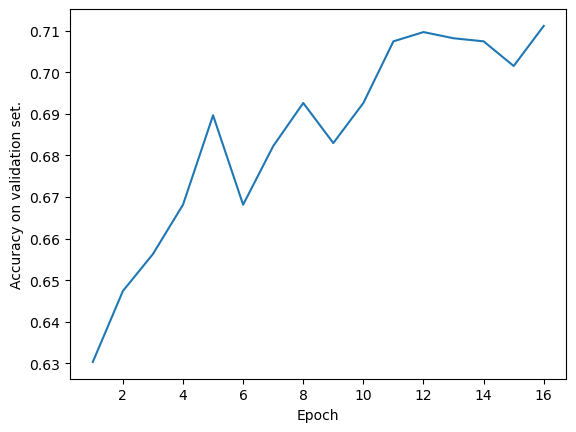

In [22]:
# (g) Tracer l'évolution des précisions tout au long de l'entraînement.
plt.plot(range(1, len(val_acc) + 1), val_acc)

plt.xlabel("Epoch")
plt.ylabel("Accuracy on validation set.")

Prédictions sur l'ensemble test.

In [23]:
# (i)
start = time.time()
val_pred = model.predict(X_val)
done = time.time()

elapsed = done - start
print(f'Prediction : {elapsed:.2f} sec \n\n')
# 0.2 sec

print(type(val_pred))  # ndarray
print(val_pred.shape)  # (2170, 1)

print(val_pred[:3, :])  # The first predictions: 1, 1, 1. 
# They are correct, although the model is only certain about the second one.

43/43 [==============================] - 0s 2ms/step
Prediction : 0.28 sec 


<class 'numpy.ndarray'>
(1350, 3)
[[0.6841387  0.03743719 0.2784241 ]
 [0.0404877  0.90389127 0.05562107]
 [0.73333627 0.22631298 0.04035073]]


In [24]:
# (k)
def pred_mat2class(pred_matrix):
    return pred_matrix.argmax(axis=1)


y_val_class = pred_mat2class(Y_val)
val_pred_class = pred_mat2class(val_pred)


print(val_pred_class[:10])  #[0 1 0 1 1 0 1 0 1 2]

[0 1 0 0 1 0 1 0 1 2]


In [25]:
print(y_val_class[:10])  # [0 1 1 0 1 0 1 0 1 2]
# The model made 2 mistakes in the first 10 images, which would be quite correct if this was generalized
# to the other images.

[0 1 1 0 1 0 1 0 1 2]


In [26]:
# score
print("Accuracy on validation set:", metrics.accuracy_score(y_val_class, val_pred_class))
# 0.665

Accuracy on validation set: 0.7111111111111111


In [27]:
# score on training set.
start = time.time()
train_pred = model.predict(X_train)
done = time.time()

elapsed = done - start
print(f'Prediction : {elapsed:.2f} sec \n\n')

y_train_class = pred_mat2class(Y_train)
train_pred_class = pred_mat2class(train_pred)

print("Accuracy on train set:", metrics.accuracy_score(y_train_class, train_pred_class))
# 0.68
# The model does not overfit.

169/169 [==============================] - 0s 2ms/step
Prediction : 0.53 sec 


Accuracy on train set: 0.7333333333333333


In [28]:
print(metrics.classification_report(y_val_class, val_pred_class))
# 0.67, 0.74, 0.58

              precision    recall  f1-score   support

           0       0.67      0.80      0.73       462
           1       0.74      0.78      0.76       434
           2       0.73      0.55      0.63       454

    accuracy                           0.71      1350
   macro avg       0.72      0.71      0.71      1350
weighted avg       0.71      0.71      0.71      1350



In [29]:
# confusion matrix
# cm = metrics.confusion_matrix(y_val_class, val_pred_class)
# print(cm)

pd.crosstab(y_val_class, val_pred_class)

col_0,0,1,2
row_0,,,
0,371,37,54
1,57,339,38
2,124,80,250


Images aléatoires du jeu de validation avec les vraies classes et les prédictions.

(<Figure size 1600x500 with 10 Axes>,
 array([<Axes: title={'center': 'True 0\nPredicted: 0'}>,
        <Axes: title={'center': 'True 2\nPredicted: 2'}>,
        <Axes: title={'center': 'True 1\nPredicted: 1'}>,
        <Axes: title={'center': 'True 2\nPredicted: 1'}>,
        <Axes: title={'center': 'True 2\nPredicted: 1'}>,
        <Axes: title={'center': 'True 1\nPredicted: 0'}>,
        <Axes: title={'center': 'True 1\nPredicted: 1'}>,
        <Axes: title={'center': 'True 1\nPredicted: 1'}>,
        <Axes: title={'center': 'True 2\nPredicted: 2'}>,
        <Axes: title={'center': 'True 0\nPredicted: 0'}>], dtype=object),
 array([ 610, 1100, 1011,  723, 1063,   36,  444,  167, 1161, 1126]))

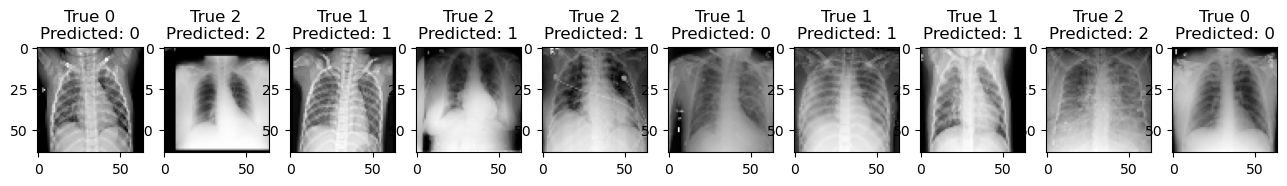

In [30]:
n_plots = 10

def tuple_str_true_pred(true:int, pred:int):
#    return "True " + str(tup[0]) + '\n' + "Predicted: " + str(tup[1])
    return "True " + str(true) + '\n' + "Predicted: " + str(pred)


# subplots_random_images(X_val, list(zip(y_val_class, val_pred_class)), n_plots, rng)

# lst_str_pred = list(map(tuple_str_true_pred, zip(y_val_class, val_pred_class)))
lst_str_pred = list(map(tuple_str_true_pred, y_val_class, val_pred_class))
subplots_random_images(X_val, lst_str_pred, n_plots, rng)
